# Synthetic ferritin data
Generation of synthetic data of ferritin rings

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from tem_staining.synthetic_data import (
    generate_ferritin_rings,
    calculate_point_distances,
)
from imageio.v3 import immeta
from sklearn.linear_model import LinearRegression
import skimage as ski
from tem_staining.spectral_analysis import power_spectrum, radially_averaged_spectrum


plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 8
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["mathtext.fontset"] = "cm"

inch_size = 2.54

## Generate synthetic data for analysis
Select areal density of 0.35 and save 10 different images. A pseudo-random number generator with fixed seed is used to reproducibly generate random seeds (up to 32 bit integers) for the images.

In [2]:
rng = np.random.default_rng(19898765351984)
plot_results = False

for random_seed in rng.integers(0, 2**32, 10):
    image, _ = generate_ferritin_rings(
        areal_fraction=0.35,
        noise_sigma=5,
        filter_sigma=1.5,
        random_state=random_seed,
    )
    image = image.astype(np.uint8)

    results_folder = Path("Data/Processed/SyntheticData")
    results_folder.mkdir(parents=True, exist_ok=True)

    cv2.imwrite(results_folder / f"SyntheticData-seed{random_seed}.tif", image)

    if plot_results:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(image, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"Random seed: {random_seed}")

## Overview of algorithm parameters
This section shows an overview of several parameters that can be passed to the generative algorithm. This is used for figures in the Supporting Information

### Areal fraction and filters (Figure S1)
Effect of areal fraction and filter parameters on the power spectrum fo generated images

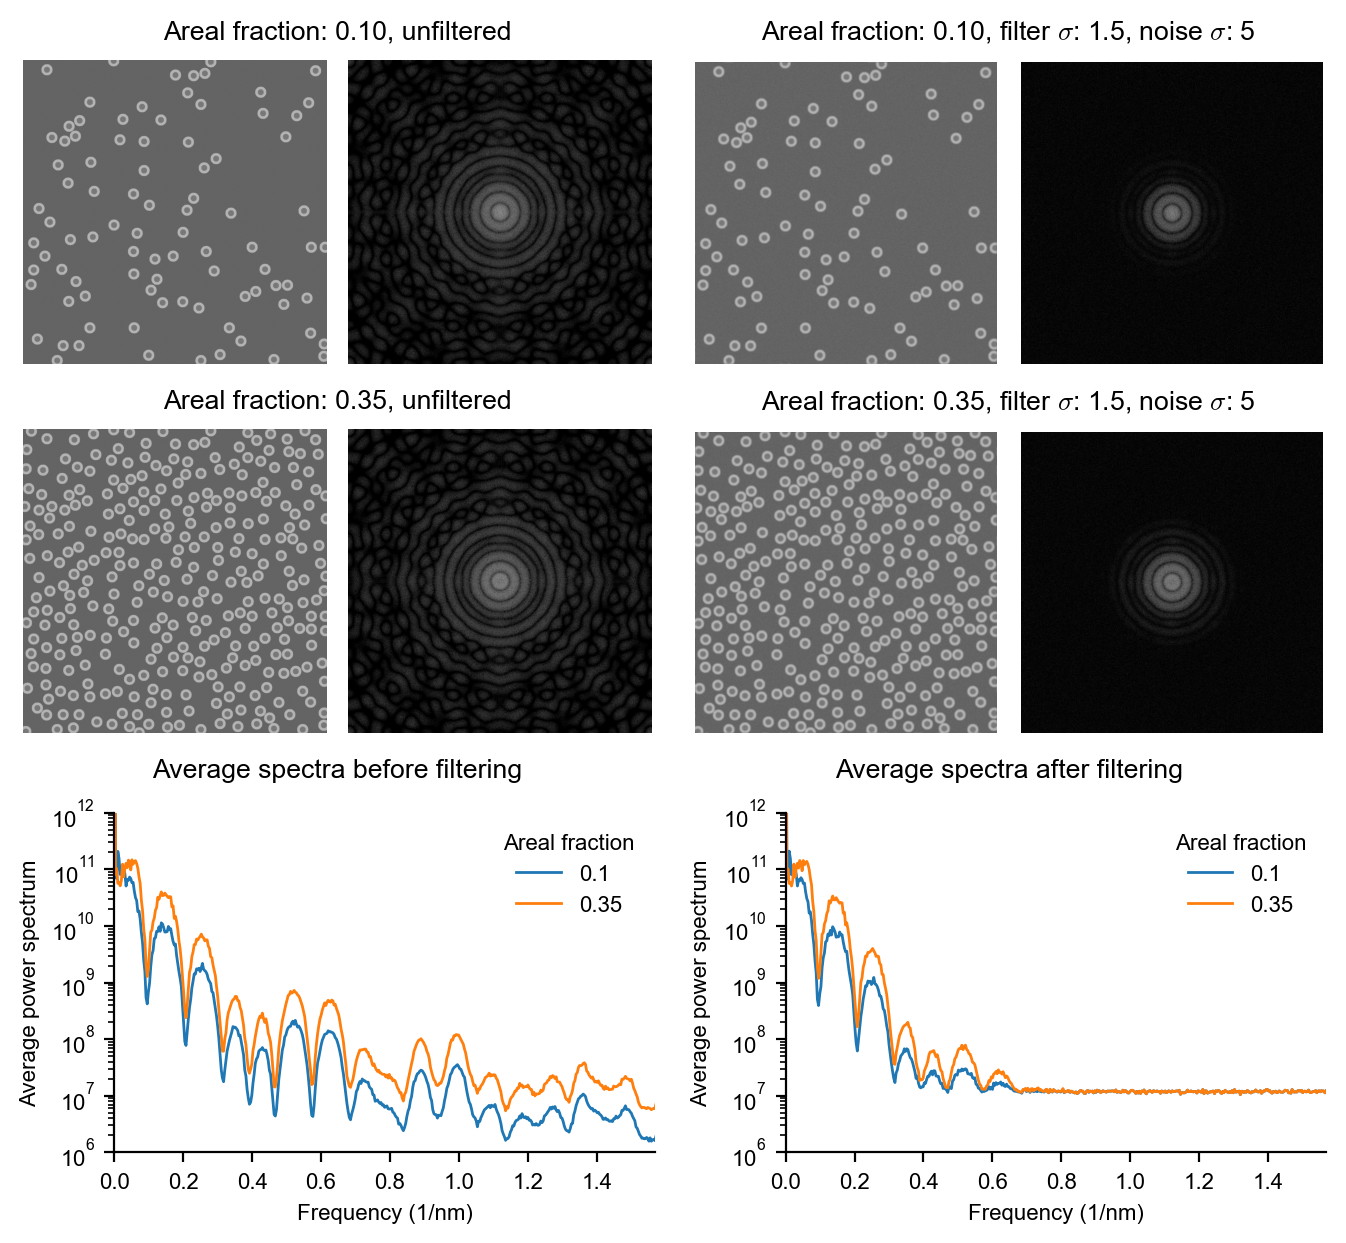

In [3]:
areal_fractions = [0.1, 0.35]
filter_sigmas = [0, 1.5]
noise_sigmas = [0, 5]
random_state = 19898765351984

save_path = Path("Data/Results/SyntheticData/Supplementary/Figure_S1")
save_path.mkdir(parents=True, exist_ok=True)
save_intermediate_figures = True

fig = plt.figure(
    layout="constrained", figsize=(16.8 / inch_size, 15.5 / inch_size), dpi=200
)
subfigs = fig.subfigures(
    3, 2, wspace=0.03, width_ratios=[1.0, 1.0], height_ratios=[0.3, 0.3, 0.4]
)

# Convert frequency units to nm^-1
metadata = immeta("Data/Raw/UA/UA-01.tif")
pixel_size = metadata["pixelsizex"] * 1e9
nyquist = 1 / (2 * pixel_size)


for col, filter_sigma in enumerate(filter_sigmas):
    raps_list = []
    for row, areal_fraction in enumerate(areal_fractions):
        noise_sigma = noise_sigmas[col]
        image, _ = generate_ferritin_rings(
            areal_fraction=areal_fraction,
            noise_sigma=noise_sigma,
            filter_sigma=filter_sigma,
            random_state=random_state,
        )
        f_magnitude = power_spectrum(image)
        raps = radially_averaged_spectrum(image)
        raps_list.append(raps)

        subfig = subfigs[row, col]
        filter_text = (
            f", filter $\sigma$: {1.5}, noise $\sigma$: {noise_sigma}"
            if filter_sigma > 0
            else ", unfiltered"
        )
        subfig.suptitle(f"Areal fraction: {areal_fraction:.2f}{filter_text}")

        ax = subfig.subplots(1, 2)
        ax[0].imshow(image, cmap="gray", vmin=0, vmax=255)
        ax[0].set_axis_off()

        ax[1].imshow(
            f_magnitude,
            cmap="gray",
            vmin=raps[:460].min(),
        )
        ax[1].set_axis_off()

        if save_intermediate_figures:
            f_magnitude_norm = ski.exposure.rescale_intensity(
                f_magnitude,
                in_range=(raps[:460].min(), f_magnitude.max()),
                out_range=(0, 1),
            )
            f_magnitude_norm = ski.util.img_as_ubyte(f_magnitude_norm)

            image_name = (
                f"SyntheticData-{random_state}-arealFraction_{areal_fraction}" +
                f"-noiseSigma_{noise_sigma}-filterSigma_{filter_sigma}"
            )

            cv2.imwrite(save_path / f"{image_name}.tif", image.astype(np.uint8))
            cv2.imwrite(save_path / f"{image_name}-power_spectrum.png", f_magnitude_norm)

    subfig = subfigs[2, col]
    spectrum_title = f"before filtering" if filter_sigma == 0 else f"after filtering"
    subfig.suptitle(f"Average spectra {spectrum_title}")
    ax = subfig.subplots()
    for raps in raps_list:
        frequency = np.arange(len(raps)) / (920 / 2) * nyquist
        ax.plot(frequency, 10**raps, lw=1)
    ax.set(
        xlabel="Frequency (1/nm)",
        ylabel="Average power spectrum",
        yscale="log",
        xlim=(0, nyquist),
        ylim=(10**6, 10**12),
    )
    ax.legend(areal_fractions, title="Areal fraction", frameon=False)
    sns.despine()

fig.savefig(save_path / "SyntheticData-filter-density-comparison.png", dpi=300)

### Areal fraction and average distance (Figure S2)
Simulation of the relationship between areal fraction and the average intermolecular distance. Average intermolecular distance is here defined as the average distance between a single simulated ferriting ring center and the centers of its nearest neighbors as defined by a Delauney triangulation

In [4]:
# Data generation for areal fraction vs average distance

areal_fractions = []
average_distances = []

rng = np.random.default_rng(19898765351984)
for areal_fraction in rng.uniform(0.05, 0.4, 400):

    image, points = generate_ferritin_rings(
        areal_fraction=areal_fraction,
        noise_sigma=0,
        filter_sigma=0,
        background_value=0,
    )

    distances = calculate_point_distances(points)
    average_distances.append(distances.mean())

    true_areal_fraction = np.mean(image > 0)
    areal_fractions.append(areal_fraction)

average_distances = np.array(average_distances)
areal_fractions = np.array(areal_fractions)
data = pd.DataFrame(
    {"areal_fraction": areal_fractions, "average_distance": average_distances}
)

results_path = Path("Data/Results/SyntheticData/Supplementary/Figure_S2")
results_path.mkdir(parents=True, exist_ok=True)
data.to_csv(results_path / "SyntheticData_average_distance.csv", index=False)

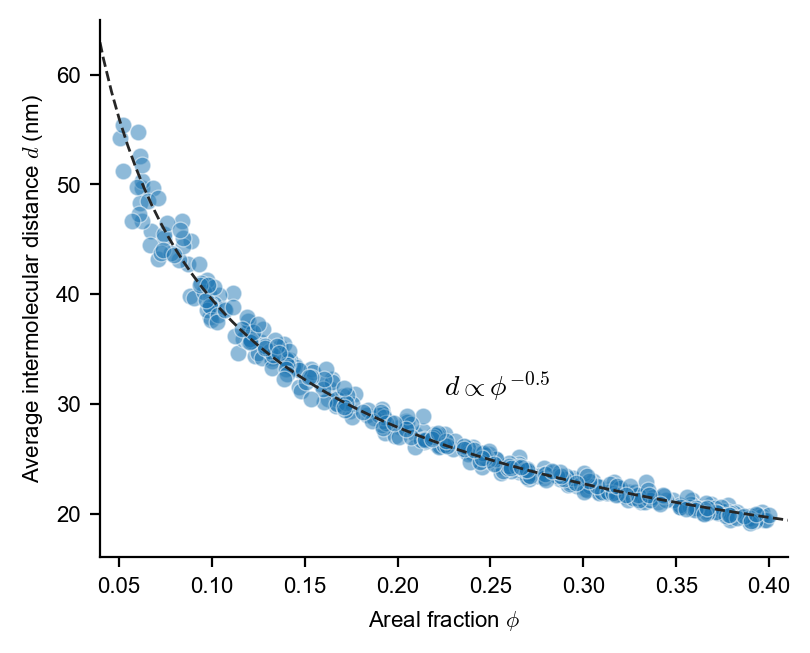

In [5]:
# Plot areal fraction vs average distance

data = pd.read_csv("Data/Results/SyntheticData/Supplementary/Figure_S2/SyntheticData_average_distance.csv")
data["average_distance"] *= pixel_size

regression = LinearRegression(fit_intercept=True).fit(
    np.log10(data["areal_fraction"].values.reshape(-1, 1)),
    np.log10(data["average_distance"].values),
)

density_range = np.linspace(0.02, 0.45, 100)
dist_predict = 10 ** regression.predict(np.log10(density_range).reshape(-1, 1))
data_predict = pd.DataFrame(
    {"areal_fraction": density_range, "predicted_distance": dist_predict}
)

fig, ax = plt.subplots(figsize=(10 / inch_size, 8 / inch_size), dpi=200)
sns.scatterplot(data=data, x="areal_fraction", y="average_distance", ax=ax, alpha=0.5)
sns.lineplot(
    data=data_predict,
    x="areal_fraction",
    y="predicted_distance",
    ax=ax,
    color="0.15",
    lw=1,
    ls="--",
)
ax.set(
    xlabel="Areal fraction $\phi$",
    ylabel="Average intermolecular distance $d$ (nm)",
    xlim=(0.04, 0.41),
    ylim=(16, 65),
)
ax.text(0.5, 0.3, r"$d \propto \phi^{-0.5}$", transform=ax.transAxes, fontsize=10)
sns.despine()

# Save figure
results_path = Path("Data/Results/SyntheticData/Supplementary/Figure_S2")
results_path.mkdir(parents=True, exist_ok=True)
fig.savefig(
    results_path / "SyntheticData_average_distance_regression.png", dpi=300
)

plt.show()